BBC Data Set Link: https://www.kaggle.com/competitions/learn-ai-bbc/data

In [ ]:
!pip install --upgrade gensim

In [ ]:
# import packages
import torch
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import OneHotEncoder

# Load Data

**Note**: Make sure your Drive is structured according to the `DATA_FOLDER` path.

This is needed for loading the data from Google Drive.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
DATA_FOLDER = "/content/drive/MyDrive/BTTAI - News AI Agent/Data"

In [ ]:
csv_path = os.path.join(f"{DATA_FOLDER}/BBC News Train.csv")
df = pd.read_csv(csv_path)

In [ ]:
df.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


In [ ]:
df.shape

(1490, 3)

In [ ]:
df.dtypes

,0
ArticleId,int64
Text,object
Category,object


## Handle Duplicates and Missing Values

In [ ]:
#checking for missing value
missing_values=df.isnull().sum()
print("missing values per column: ")
print(missing_values)

duplicate_rows = df.duplicated().sum()
print("\nNumber of duplicate rows:")
print(duplicate_rows)

missing values per column: 
ArticleId    0
Text         0
Category     0
dtype: int64

Number of duplicate rows:
0


In [ ]:
to_encode = ['Category']
print(to_encode)

# Performing one hot encoding
enc = OneHotEncoder(sparse_output=False, handle_unknown='ignore')
encoded = enc.fit_transform(df[to_encode])

# Create a DataFrame with the one-hot encoded columns
encoded_df = pd.DataFrame(encoded, columns=enc.get_feature_names_out(to_encode), index=df.index)
display(encoded_df.head())

['Category']


,Category_business,Category_entertainment,Category_politics,Category_sport,Category_tech
0,1.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,1.0
4,1.0,0.0,0.0,0.0,0.0


### Sample Data Point

In [ ]:
(df.iloc[2]['Text'])

'bbc poll indicates economic gloom citizens in a majority of nations surveyed in a bbc world service poll believe the world economy is worsening.  most respondents also said their national economy was getting worse. but when asked about their own family s financial outlook  a majority in 14 countries said they were positive about the future. almost 23 000 people in 22 countries were questioned for the poll  which was mostly conducted before the asian tsunami disaster. the poll found that a majority or plurality of people in 13 countries believed the economy was going downhill  compared with respondents in nine countries who believed it was improving. those surveyed in three countries were split. in percentage terms  an average of 44% of respondents in each country said the world economy was getting worse  compared to 34% who said it was improving. similarly  48% were pessimistic about their national economy  while 41% were optimistic. and 47% saw their family s economic conditions impr

In [ ]:
len(df.iloc[2]['Text'].lower())

3104

# Milestone 2: Preprocess Data

**Note**: Modify the `df_clean` data frame for preprocessing so we preserve the raw `df` data.

In [ ]:
# Make a copy of original data set for preprocessing
df_clean = df.copy()

## Stop Word Removal and Lemmatization

In [ ]:
import re
import string

def processed_text(raw_text):
    # fix contractions ("i m" -> "i am")
    fixed_contractions = fix_split_contractions(raw_text)

    # normalize text before stop word removal and lemmatization
    normalized_text = normalize_txt(fixed_contractions)

    # stop word removal
    no_stop_word_text = remove_stopwords_and_punct(normalized_text)

    # lemmatization
    lemmatized_text = lemmatize_text(no_stop_word_text)

    return lemmatized_text

functions

In [ ]:
def fix_split_contractions(text):
    # negative contractions
    text = re.sub(r"\bi m\b", "i am", text)
    text = re.sub(r"\bisn t\b", "is not", text)
    text = re.sub(r"\baren t\b", "are not", text)
    text = re.sub(r"\bwasn t\b", "was not", text)
    text = re.sub(r"\bweren t\b", "were not", text)
    text = re.sub(r"\bdon t\b", "do not", text)
    text = re.sub(r"\bdoesn t\b", "does not", text)
    text = re.sub(r"\bdidn t\b", "did not", text)
    text = re.sub(r"\bcan t\b", "cannot", text)
    text = re.sub(r"\bwon t\b", "will not", text)
    text = re.sub(r"\bwouldn t\b", "would not", text)
    text = re.sub(r"\bshouldn t\b", "should not", text)
    # positive contractions
    text = re.sub(r"\bthat s\b", "that is", text)
    text = re.sub(r"\bthere s\b", "there is", text)
    text = re.sub(r"\bit s\b", "it is", text)
    text = re.sub(r"\bhe s\b", "he is", text)
    text = re.sub(r"\bshe s\b", "she is", text)
    text = re.sub(r"\bwe re\b", "we are", text)
    text = re.sub(r"\bthey re\b", "they are", text)

    return text

In [ ]:
def normalize_txt(raw_text):
    # Collapse multiple spaces
    n_text = re.sub(r"\s+", " ", raw_text)

    # Remove spaces before punctuation (e.g. "hello , world" -> "hello, world")
    n_text = re.sub(r"\s([?.!,;:])", r"\1", n_text)

    # Merge numbers split by spaces or commas (e.g. "25 000" or "25,000" -> "25000")
    n_text = re.sub(r"(\d)[\s,]+(\d)", r"\1\2", n_text)

    # Fix cases like "family s" -> "family"
    n_text = re.sub(r"\b(\w+) s\b", r"\1", n_text)

    # URLs → replace with "URL"
    n_text = re.sub(r'http\S+|www\.\S+', 'URL', n_text)

    # Emails → replace with "EMAIL"
    n_text = re.sub(r'\S+@\S+\.\S+', 'EMAIL', n_text)

    # Currency → remove $ or € signs (keep numbers)
    n_text = re.sub(r'[$€£]', '', n_text)

    return n_text

In [ ]:
import nltk
nltk.download('punkt_tab')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [ ]:
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

nltk.download('stopwords', quiet=True)
nltk.download('punkt', quiet=True)

stopwords = set(stopwords.words('english'))

def remove_stopwords_and_punct(normalized_text):
  tokenized_text = word_tokenize(normalized_text)
  filtered_tokens = []
  for token in tokenized_text:
    if token not in stopwords and token not in string.punctuation:
      filtered_tokens.append(token)
  return " ".join(filtered_tokens)


In [ ]:
import nltk
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from nltk.corpus import wordnet
from nltk.tokenize import RegexpTokenizer


nltk.download('wordnet', quiet=True)
nltk.download('omw-1.4', quiet=True)
nltk.download('punkt_tab',quiet=True)
nltk.download('averaged_perceptron_tagger_eng', quiet=True)

lemmatizer = WordNetLemmatizer()

def get_wordnet_pos(n_tag):
    """Convert treebank POS tags to WordNet POS tags"""
    if n_tag.startswith('J'):
        return wordnet.ADJ
    elif n_tag.startswith('V'):
        return wordnet.VERB
    elif n_tag.startswith('N'):
        return wordnet.NOUN
    elif n_tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # default

def lemmatize_text(text):
    """
    Lemmatize a text string while skipping tokens of length ≤2 to preserve
    short words like 'us' and avoid artifacts like 'u'.
    """
    # Tokenize with proper tokenizer

    # tokenizer = RegexpTokenizer(r'\d+%?|\w+')
    # tokens = tokenizer.tokenize(text)
    tokens = word_tokenize(text)

    # Get NLTK POS tags
    pos_tags = nltk.pos_tag(tokens)

    # Lemmatize with POS information
    lemmatized_tokens = []
    for word, tag in pos_tags:
      if len(word) <= 2:
            # Skip lemmatization for short tokens
            lemmatized_tokens.append(word)
      else:
        pos = get_wordnet_pos(tag) # convert NLTK to wordnet POS tags
        lemma = lemmatizer.lemmatize(word, pos=pos)
        lemmatized_tokens.append(lemma)

    return " ".join(lemmatized_tokens)

function calls

In [ ]:
# sample data
sample = "but when asked about their own family s financial outlook  a majority said i m ok but the world isn t. at the us telecoms. is be go do  "
print("Original:", sample)

sample_clean = fix_split_contractions(sample)
print("\nfixed contractions:", sample_clean)
sample_clean = normalize_txt(sample_clean)
print("normalized:", sample_clean)
sample_clean = remove_stopwords_and_punct(sample_clean)
print("stop word removal:", sample_clean)
sample_clean = lemmatize_text(sample_clean)
print("lemmatized:", sample_clean)

print("\nFully Processed:", processed_text(sample))

Original: but when asked about their own family s financial outlook  a majority said i m ok but the world isn t. at the us telecoms. is be go do  

fixed contractions: but when asked about their own family s financial outlook  a majority said i am ok but the world is not. at the us telecoms. is be go do  
normalized: but when asked about their own family financial outlook a majority said i am ok but the world is not. at the us telecoms. is be go do 
stop word removal: asked family financial outlook majority said ok world us telecoms go
lemmatized: ask family financial outlook majority say ok world us telecom go

Fully Processed: ask family financial outlook majority say ok world us telecom go


In [ ]:
# Created own separate function call for stop words

sample = "This is just a simple !test! sentence."
processed = remove_stopwords_and_punct(sample)
print("Original:", sample)
print("Processed:", processed)


Original: This is just a simple !test! sentence.
Processed: This simple test sentence


In [ ]:
df_clean['cleaned_txt'] = df_clean['Text'].apply(processed_text)

In [ ]:
print(df_clean[["Text", "cleaned_txt"]].head())

                                                Text  \
0  worldcom ex-boss launches defence lawyers defe...   
1  german business confidence slides german busin...   
2  bbc poll indicates economic gloom citizens in ...   
3  lifestyle  governs mobile choice  faster  bett...   
4  enron bosses in $168m payout eighteen former e...   

                                         cleaned_txt  
0  worldcom ex-boss launch defence lawyer defend ...  
1  german business confidence slides german busin...  
2  bbc poll indicate economic gloom citizen major...  
3  lifestyle governs mobile choice faster well fu...  
4  enron boss 168m payout eighteen former enron d...  


## Handle Outliers

Remove articles with lengths in the bottom 1% and top 1%.

Result: 1460 Data Points (originally 1490), dropped 30 data points.  

Plots are added for visualization.

Cleaned data is in `df_clean`

In [ ]:
# Compute lengths of each article and summary stats
lengths = df_clean['cleaned_txt'].apply(len)

maxLen = lengths.max()
minLen = lengths.min()
meanLen = lengths.mean()
medianLen = lengths.median()

print("Summary of text lengths:")
print(f"Min: {minLen}, Max: {maxLen}, Mean: {meanLen:.1f}, Median: {medianLen}")

Summary of text lengths:
Min: 327, Max: 11186, Mean: 1483.2, Median: 1311.0


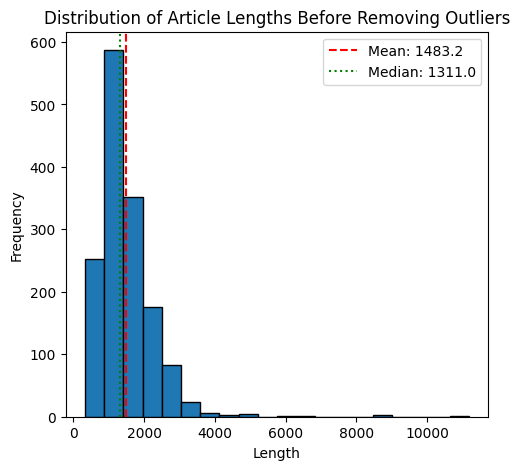

In [ ]:
# Plot Distribution of Article Lengths (Before Removing Outliers)
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(lengths, bins=20, edgecolor='black')
plt.axvline(meanLen, color='red', linestyle='--', label=f'Mean: {meanLen:.1f}')
plt.axvline(medianLen, color='green', linestyle=':', label=f'Median: {medianLen:.1f}')
plt.title("Distribution of Article Lengths Before Removing Outliers")
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.legend()

In [ ]:
# Compute 1th Percentile and 99th Percentile (Top 1% and Bottom 1%)
length_1 = np.percentile(lengths, 1)
length_99 = np.percentile(lengths, 99.0)

print(f'1th percentile: {length_1:.1f}')
print(f'99th percentile: {length_99:.1f}')

1th percentile: 533.2
99th percentile: 3773.0


In [ ]:
# Filter for Articles Within Percentiles
df_clean = df_clean[(lengths >= length_1) & (lengths <= length_99)]

print(f'Number of data points after removing outliers: {len(df_clean)}')

Number of data points after removing outliers: 1460


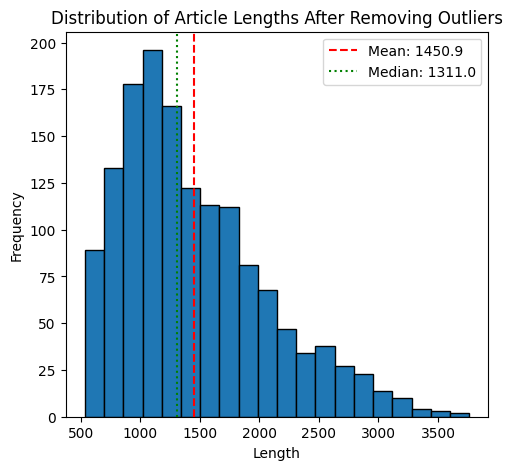

In [ ]:
# Plot Distribution of Article Lengths (After Removing Outliers)
lengths_cleaned = df_clean['cleaned_txt'].apply(len)

maxLen = lengths_cleaned.max()
minLen = lengths_cleaned.min()
meanLen = lengths_cleaned.mean()
medianLen = lengths_cleaned.median()

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(lengths_cleaned, bins=20, edgecolor='black')
plt.axvline(meanLen, color='red', linestyle='--', label=f'Mean: {meanLen:.1f}')
plt.axvline(medianLen, color='green', linestyle=':', label=f'Median: {medianLen:.1f}')
plt.title("Distribution of Article Lengths After Removing Outliers")
plt.xlabel("Length")
plt.ylabel("Frequency")
plt.legend()

In [ ]:
print("Summary of text lengths after removing outliers:")
print(f"Min: {minLen}, Max: {maxLen}, Mean: {meanLen:.1f}, Median: {medianLen}")

Summary of text lengths after removing outliers:
Min: 534, Max: 3762, Mean: 1450.9, Median: 1311.0


## Confirm if the classes are balanced and rebalance

In [ ]:
category_counts = df_clean['Category'].value_counts()

In [ ]:
print(category_counts)

Category
business         336
sport            329
politics         271
entertainment    269
tech             255
Name: count, dtype: int64


Average articles per category: 292.0


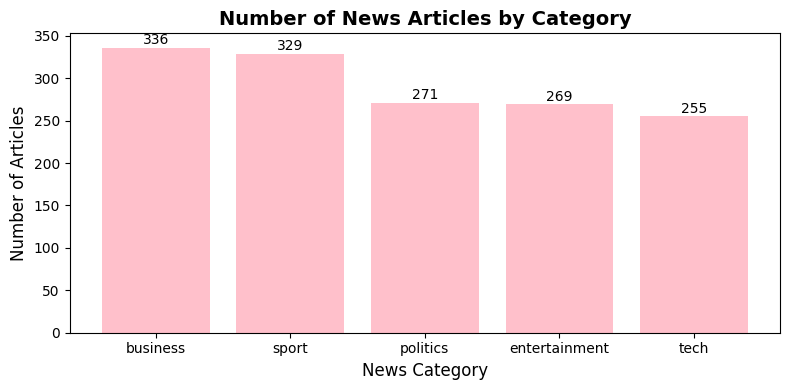

In [ ]:
# checking the balance in bar chart

#average articles per category
avg_articles = len(df_clean) / len(category_counts)
print(f"Average articles per category: {avg_articles:.1f}")

plt.figure(figsize=(8, 4))

# create bar chart
bars = plt.bar(category_counts.index, category_counts.values, color = "pink")

# label the chart
plt.title('Number of News Articles by Category', fontsize=14, fontweight='bold')
plt.xlabel('News Category', fontsize=12)
plt.ylabel('Number of Articles', fontsize=12)


# add numbers on top of each bar
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.5,
             f'{int(height)}', ha='center', va='bottom')

plt.tight_layout()
plt.show()


In [ ]:
LOWER_BOUND = 0.67   # 2/3 of average
UPPER_BOUND = 1.5    # 3/2 of average

for category, count in category_counts.items():
    ratio = count / avg_articles
    if LOWER_BOUND <= ratio <= UPPER_BOUND:
        print(f"{category}: Balanced ({ratio:.1%} of average)")
    else:
        print(f"{category}: Imbalanced ({ratio:.1%} of average)")

business: Balanced (115.1% of average)
sport: Balanced (112.7% of average)
politics: Balanced (92.8% of average)
entertainment: Balanced (92.1% of average)
tech: Balanced (87.3% of average)


## EDA

In [ ]:
print("Number of articles:", len(df_clean))
print("Categories:", df_clean['Category'].unique())
print("Category distribution:")
print(df_clean['Category'].value_counts())

Number of articles: 1460
Categories: ['business' 'tech' 'politics' 'sport' 'entertainment']
Category distribution:
Category
business         336
sport            329
politics         271
entertainment    269
tech             255
Name: count, dtype: int64


Average word count: 214.30342465753424


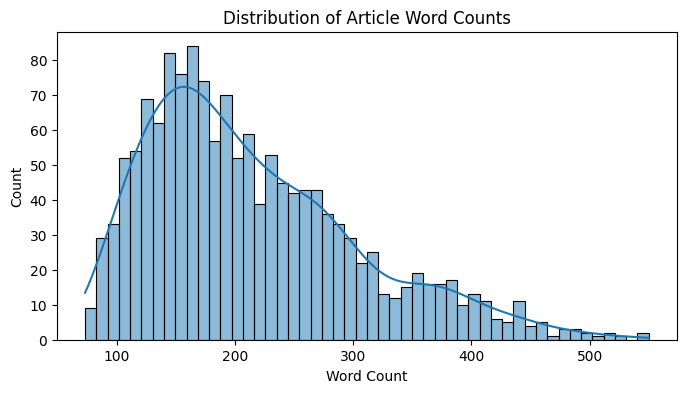

Summary of word count statistics:
Min: 73
Max: 550
Mean: 214.3
Median: 193.0


In [ ]:
word_count = df_clean['cleaned_txt'].apply(lambda x: len(x.split()))
print("Average word count:", word_count.mean())

plt.figure(figsize=(8,4))
sns.histplot(word_count, bins=50, kde=True)
plt.title("Distribution of Article Word Counts")
plt.xlabel("Word Count")
plt.show()

min_words = word_count.min()
max_words = word_count.max()
mean_words = word_count.mean()
median_words = word_count.median()

print("Summary of word count statistics:")
print(f"Min: {min_words}")
print(f"Max: {max_words}")
print(f"Mean: {mean_words:.1f}")
print(f"Median: {median_words}")

Most common words: [('say', 5778), ('mr', 1952), ('year', 1798), ('would', 1659), ('also', 1390), ('make', 1370), ('new', 1266), ('people', 1251), ('us', 1211), ('one', 1126), ('take', 1111), ('go', 1056), ('could', 990), ('get', 943), ('game', 942), ('use', 918), ('time', 904), ('last', 869), ('first', 813), ('two', 785)]


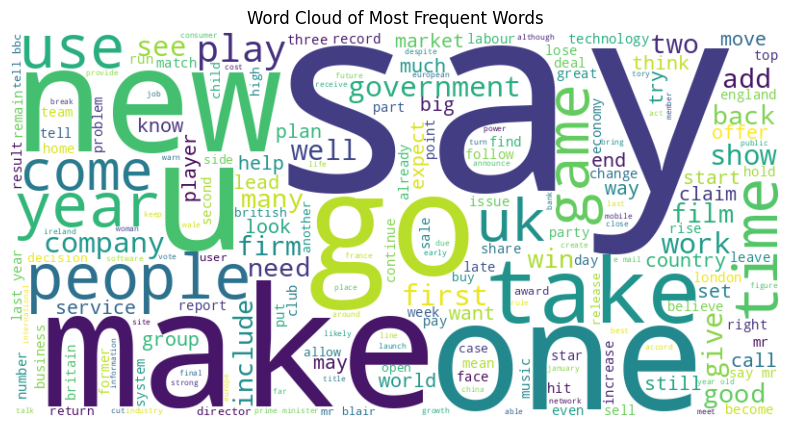

In [ ]:
from wordcloud import WordCloud
from collections import Counter
all_words = " ".join(df_clean['cleaned_txt']).split()
word_freq = Counter(all_words)

print("Most common words:", word_freq.most_common(20))

# WordCloud
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(all_words))
plt.figure(figsize=(10,5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Word Cloud of Most Frequent Words")
plt.show()

In [ ]:
for category in df_clean['Category'].unique():
    words = " ".join(df_clean[df_clean['Category'] == category]['cleaned_txt']).split()
    word_freq = Counter(words)
    print(f"\nTop words for category '{category}':")
    print(word_freq.most_common(10))


Top words for category 'business':
[('say', 1279), ('year', 574), ('us', 511), ('mr', 394), ('company', 392), ('firm', 375), ('market', 345), ('would', 309), ('also', 279), ('sale', 276)]

Top words for category 'tech':
[('say', 1245), ('people', 626), ('use', 569), ('game', 417), ('make', 377), ('technology', 374), ('mobile', 368), ('service', 364), ('phone', 353), ('new', 341)]

Top words for category 'politics':
[('say', 1855), ('mr', 1066), ('would', 699), ('labour', 483), ('government', 451), ('election', 434), ('party', 409), ('blair', 384), ('minister', 369), ('people', 335)]

Top words for category 'sport':
[('say', 725), ('game', 437), ('win', 384), ('play', 367), ('england', 325), ('go', 315), ('take', 294), ('make', 291), ('player', 291), ('get', 289)]

Top words for category 'entertainment':
[('say', 674), ('film', 654), ('best', 389), ('year', 379), ('award', 324), ('star', 309), ('show', 287), ('also', 270), ('one', 256), ('us', 256)]


In [ ]:
df_clean['Text'][1]

'german business confidence slides german business confidence fell in february knocking hopes of a speedy recovery in europe s largest economy.  munich-based research institute ifo said that its confidence index fell to 95.5 in february from 97.5 in january  its first decline in three months. the study found that the outlook in both the manufacturing and retail sectors had worsened. observers had been hoping that a more confident business sector would signal that economic activity was picking up.   we re surprised that the ifo index has taken such a knock   said dz bank economist bernd weidensteiner.  the main reason is probably that the domestic economy is still weak  particularly in the retail trade.  economy and labour minister wolfgang clement called the dip in february s ifo confidence figure  a very mild decline . he said that despite the retreat  the index remained at a relatively high level and that he expected  a modest economic upswing  to continue.  germany s economy grew 1.

In [ ]:
df_clean['cleaned_txt'][1]

'german business confidence slides german business confidence fell february knocking hop speedy recovery europe large economy munich-based research institute ifo say confidence index fell 95.5 february 97.5 january first decline three month study find outlook manufacture retail sector worsen observer hop confident business sector would signal economic activity pick surprise ifo index take knock say dz bank economist bernd weidensteiner main reason probably domestic economy still weak particularly retail trade economy labour minister wolfgang clement call dip february ifo confidence figure mild decline say despite retreat index remain relatively high level expect modest economic upswing continue germany economy grow 1.6 last year shrink 2003. however economy contract 0.2 last three month 2004 mainly due reluctance consumer spend late indication growth still prove elusive ifo president hans-werner sinn say improvement german domestic demand sluggish export keep thing go first half 2004 d

In [ ]:
df_clean['word_count'] = df_clean['cleaned_txt'].apply(lambda x: len(x.split()))

average_words = df_clean['word_count'].mean()

print("Average number of words per article:", average_words)

Average number of words per article: 214.30342465753424


## Download data to drive

In [ ]:
# df_clean.to_csv('cleaned_news.csv', index=False)

# from google.colab import files

# files.download('cleaned_news.csv')



# Milestone 3: Turn Text into Numerical Data

The goal should be to make a function that takes in text and returns the features. Make some “dummy data”, that are already cleaned in very short sentences. Use those as test inputs. When the milestone 2 and 3 are complete, we can just plug in those real inputs in the functions.

## Create Dummy Data

In [ ]:
# Create Dummy Data
dummy_data = {
    "ArticleId": [1, 2, 3, 4, 5],
    "Text": [
        "The soccer team won their match yesterday.",     # sport
        "Stock markets rose rose slightly this morning.",      # business
        "The new green energy law was passed yesterday.", # politics
        "A new movie topped the box office this week.",   # entertainment
        "A new smartphone model was released globally."   # tech
    ],
    "Category": ["sport", "business", "politics", "entertainment", "tech"]
}

df_dummy = pd.DataFrame(dummy_data)
df_dummy.head()

,ArticleId,Text,Category
0,1,The soccer team won their match yesterday.,sport
1,2,Stock markets rose rose slightly this morning.,business
2,3,The new green energy law was passed yesterday.,politics
3,4,A new movie topped the box office this week.,entertainment
4,5,A new smartphone model was released globally.,tech


## Bag of Words Function

In [ ]:
#test example on dummy data
def bow_test(data: pd.Series):
  #Create Bag of Words vectorizer object
  bow_vectorizer = CountVectorizer(lowercase=True, stop_words='english')

  #Fit vectorizer on data
  bow_vectorizer.fit(data)

  #Print vocabulary info
  print("Vocabulary size: ", len(bow_vectorizer.vocabulary_))
  print("Sample of vocabulary: ", list(bow_vectorizer.vocabulary_.items())[:50], "\n")

  #Transform into vectors
  bow_matrix = bow_vectorizer.transform(data)
  print("BoW matrix shape:", bow_matrix.shape)
  matrix_dense = bow_matrix.todense()
  print(matrix_dense)

  #heatmap

  print("\nHeatmap of BoW Matrix:\n")

  df_print = pd.DataFrame(bow_matrix.toarray(),columns=bow_vectorizer.get_feature_names_out())
  plt.figure(figsize=(min(15, len(bow_vectorizer.vocabulary_) / 2),
                        min(8, len(data) / 2)))

  ax = sns.heatmap(
      df_print,
      annot=True,
      cmap='coolwarm',
      cbar=False,
      yticklabels=[f"doc{i+1}" for i in range(len(data))]
  )

  plt.title("Bag of Words Heatmap")
  plt.xlabel("Terms")
  plt.ylabel("Frequenciess")
  plt.show()

  return bow_matrix

Vocabulary size:  24
Sample of vocabulary:  [('soccer', 17), ('team', 19), ('won', 22), ('match', 6), ('yesterday', 23), ('stock', 18), ('markets', 5), ('rose', 14), ('slightly', 15), ('morning', 8), ('new', 10), ('green', 3), ('energy', 1), ('law', 4), ('passed', 12), ('movie', 9), ('topped', 20), ('box', 0), ('office', 11), ('week', 21), ('smartphone', 16), ('model', 7), ('released', 13), ('globally', 2)] 

BoW matrix shape: (5, 24)
[[0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 0 0 1 0 1 0 0 1 1]
 [0 0 0 0 0 1 0 0 1 0 0 0 0 0 2 1 0 0 1 0 0 0 0 0]
 [0 1 0 1 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 0 0 0 0 1]
 [1 0 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 1 1 0 0]
 [0 0 1 0 0 0 0 1 0 0 1 0 0 1 0 0 1 0 0 0 0 0 0 0]]

Heatmap of BoW Matrix:



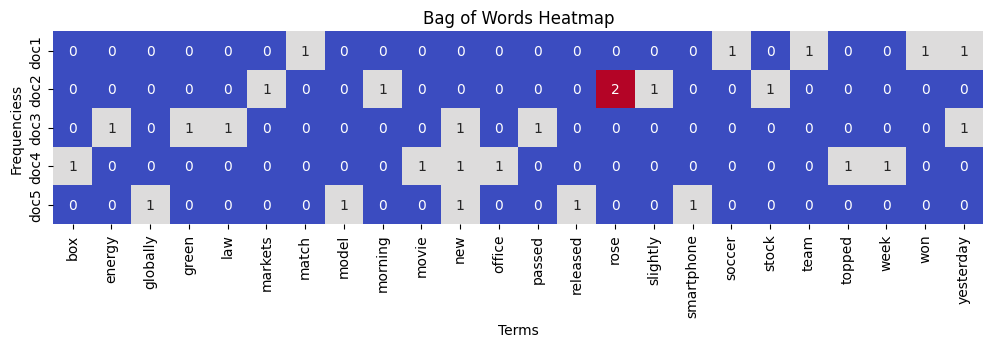

<Compressed Sparse Row sparse matrix of dtype 'int64'
	with 27 stored elements and shape (5, 24)>

In [ ]:
bow_test(df_dummy['Text'])

In [ ]:
#Actual BoW function (return_vectorizer for exploration purposes)
def bow(X_train: pd.Series, X_test: pd.Series, return_vectorizer=False):
  #Create Bag of Words vectorizer object
  bow_vectorizer = CountVectorizer(
    lowercase=True,
    stop_words='english',
    token_pattern=r"(?u)\b[a-zA-Z]{2,}\b"  # only words with 2+ letters
  )

  #Fit vectorizer on train data
  bow_vectorizer.fit(X_train)

  #Transform both training and testing data
  X_train_bow = bow_vectorizer.transform(X_train)
  X_test_bow = bow_vectorizer.transform(X_test)

  # Print info
  print(f"Vocabulary size: {len(bow_vectorizer.vocabulary_)}")
  print(f"Training matrix shape: {X_train_bow.shape}")
  print(f"Testing matrix shape: {X_test_bow.shape}")

  if return_vectorizer:
      return X_train_bow, X_test_bow, bow_vectorizer
  else:
      return X_train_bow, X_test_bow


## TF-IDF Function

In [ ]:
#test example on dummy data
def tf_idf_test(data: pd.Series):
  """
  Learn vocabulary and IDF from the dummy data to test/visualize the data with TF-IDF vectorizer.

  Args:
      X_train (pd.Series): training data documents (text column)

  Returns:
      - scipy.sparse.csr_matrix: sparse matrix of vector representation of training documents
              (shape = [n_training_documents, n_words], rows = documents, columns = terms in learned vocabulary of all documents)

  """
  #create vectorizer obj
  tfidf_vectorizer = TfidfVectorizer(lowercase=True,stop_words='english')

  #fit vectorizer to train data (learn)
  tfidf_vectorizer.fit(data)

  #print vocab
  print("Vocabulary size {0}: ".format(len(tfidf_vectorizer.vocabulary_)))
  print(str(list(tfidf_vectorizer.vocabulary_.items())[0:50])+'\n')

  # transform data in vectors
  print("Matrix:\n")
  resulting_matrix = tfidf_vectorizer.transform(data)
  matrix = resulting_matrix.todense()
  print(resulting_matrix.shape)
  print(resulting_matrix.todense())

  #visualize
  print("\nHeatmap of Matrix:\n")
  plt.figure(figsize=(min(15, len(tfidf_vectorizer.vocabulary_)/2), min(8,len(data)/2)))
  df_print = pd.DataFrame(resulting_matrix.toarray(), columns=tfidf_vectorizer.get_feature_names_out())
  plt.rcParams['figure.figsize'] = [len(data), len(tfidf_vectorizer.vocabulary_)]
  ax = sns.heatmap(
      df_print,
      annot=True,
      cmap='coolwarm',
      cbar=False,
      yticklabels=[f"doc{i+1}" for i in range(len(data))]  # match rows
  )

Vocabulary size 24: 
[('soccer', 17), ('team', 19), ('won', 22), ('match', 6), ('yesterday', 23), ('stock', 18), ('markets', 5), ('rose', 14), ('slightly', 15), ('morning', 8), ('new', 10), ('green', 3), ('energy', 1), ('law', 4), ('passed', 12), ('movie', 9), ('topped', 20), ('box', 0), ('office', 11), ('week', 21), ('smartphone', 16), ('model', 7), ('released', 13), ('globally', 2)]

Matrix:

(5, 24)
[[0.         0.         0.         0.         0.         0.
  0.46369322 0.         0.         0.         0.         0.
  0.         0.         0.         0.         0.         0.46369322
  0.         0.46369322 0.         0.         0.46369322 0.37410477]
 [0.         0.         0.         0.         0.         0.4472136
  0.         0.         0.4472136  0.         0.         0.
  0.         0.         0.4472136  0.4472136  0.         0.
  0.4472136  0.         0.         0.         0.         0.        ]
 [0.         0.4428322  0.         0.4428322  0.4428322  0.
  0.         0.      

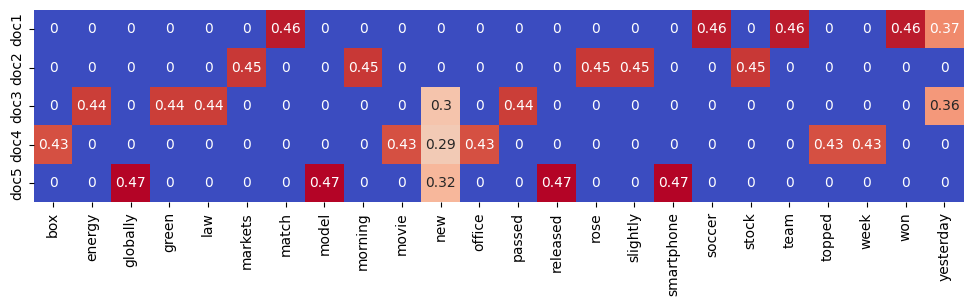

In [ ]:
#test tf_idf on dummy data
tf_idf_test(df_dummy['Text'])

In [ ]:
#tf_idf for actual pipeline (return_vectorizor variable for exploration purposes)
def tf_idf(X_train: pd.Series, X_test: pd.Series, return_vectorizer=False):
  """
  Learn vocabulary and IDF from the training data to be used in the pipeline.

  Args:
      X_train (pd.Series): training data text documents (text column)
      X_test (pd.Series): testing data text documents (text column)
  Returns:
      tuple:
            - scipy.sparse.csr_matrix: sparse matrix of vector representation of training documents
              (shape = [n_training_documents, n_words], rows = documents, columns = terms in learned vocabulary of all documents)
             - scipy.sparse.csr_matrix: sparse matrix of vector representation of training documents
              (shape = [n_testing_documents, n_words], rows = documents, columns = terms in the learned vocabulary of all documents)
  """

  #create vectorizer obj
  # tfidf_vectorizer = TfidfVectorizer(lowercase=True, stop_words='english')
  tfidf_vectorizer = TfidfVectorizer(lowercase=True, stop_words='english', ngram_range=(1, 2)) # include unigrams and bigrams

  #fit vectorizer to data
  tfidf_vectorizer.fit(X_train['Text'])

  # transform training + testing data into vectors
  X_train_tfidf= tfidf_vectorizer.transform(X_train['Text'])
  X_test_tfidf = tfidf_vectorizer.transform(X_test['Text'])

  #print info
  print(f"Vocabulary size: {len(tfidf_vectorizer.vocabulary_)}")
  print(f"Training matrix shape: {X_train_tfidf.shape}")
  #print(X_train_tfidf.todense()) #commented out for minimal logging
  print(f"Testing matrix shape: {X_test_tfidf.shape}")
  #print(X_test_tfidf.todense())

  if return_vectorizer:
      return X_train_tfidf, X_test_tfidf, tfidf_vectorizer
  else:
      return X_train_tfidf, X_test_tfidf

In [ ]:
#test tf_idf on full dataset (embedded into pipeline)
# X_train_tfidf, X_test_tfidf = tf_idf(X_train['Text'], X_test['Text'])

## Word Embeddings (Word2Vec) Function

In [ ]:
import gensim
from gensim.models import Word2Vec
from nltk.tokenize import word_tokenize

Vocabulary size: 28
Vector for 'soccer':
 [-0.00024713  0.0017674  -0.0141913   0.00412784 -0.00286456  0.00560221
  0.00968533 -0.00269993 -0.00555589  0.01547288]
Most similar to 'soccer': [('smartphone', 0.19231241941452026), ('green', 0.19210955500602722), ('released', 0.14354637265205383), ('law', 0.13577492535114288), ('this', 0.13032571971416473), ('rose', 0.12148923426866531), ('was', 0.05311828851699829), ('stock', 0.05005085840821266), ('team', 0.04649216681718826), ('slightly', 0.03216516599059105)]
Shape of embeddings matrix: (5, 50)

Heatmap of Word2Vec Embeddings:



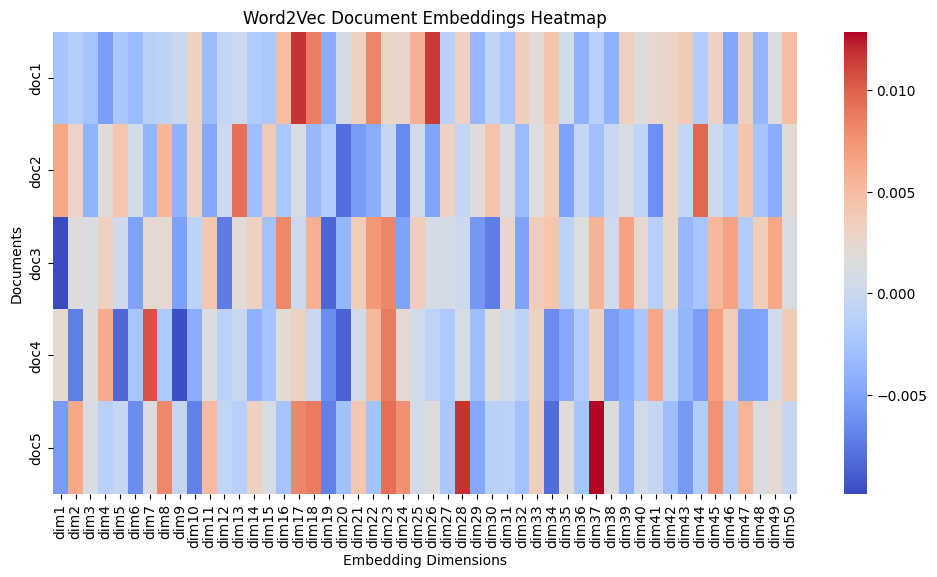

,Text
0,"[-0.0025519915, -0.0014657436, -0.0025963874, ..."
1,"[0.0063172854, 0.0028928577, -0.00382082, 0.00..."
2,"[-0.009838064, 0.0017179053, 0.0011939387, 0.0..."
3,"[0.002289845, -0.007176223, 0.0017591745, 0.00..."
4,"[-0.005407855, 0.0063005923, 0.0010939102, -0...."


In [ ]:
def word2vec_test(data: pd.Series):

    # Clean and tokenize dummy data
    tokens = data.apply(lambda x: gensim.utils.simple_preprocess(x))

    # Train Word2Vec
    wv_model = Word2Vec(sentences=tokens, vector_size=50, window=4, min_count=1, sg=1, workers=4)

    print("Vocabulary size:", len(wv_model.wv))

    # Show example: vector for 'soccer'
    if "soccer" in wv_model.wv:
        print("Vector for 'soccer':\n", wv_model.wv["soccer"][:10])  # first 10 numbers
        print("Most similar to 'soccer':", wv_model.wv.most_similar("soccer"))

    # Convert each dummy doc → vector (average word vectors)
    def document_vector(tokens):
        tokens = [w for w in tokens if w in wv_model.wv]
        if len(tokens) == 0:
            return np.zeros(wv_model.vector_size)
        return np.mean(wv_model.wv[tokens], axis=0)

    embeddings = tokens.apply(document_vector)
    print("Shape of embeddings matrix:", np.vstack(embeddings.values).shape)


    # heatmap

    embeddings = tokens.apply(document_vector)
    matrix = np.vstack(embeddings.values)

    print("\nHeatmap of Word2Vec Embeddings:\n")

    embedding_matrix = np.vstack(embeddings.values)
    df_embed = pd.DataFrame(embedding_matrix,
                            columns=[f"dim{i+1}" for i in range(embedding_matrix.shape[1])])

    plt.figure(figsize=(12, 6))

    sns.heatmap(df_embed,
                annot=False,
                cmap="coolwarm",
                cbar=True,
                yticklabels=[f"doc{i+1}" for i in range(len(data))])

    plt.title("Word2Vec Document Embeddings Heatmap")
    plt.xlabel("Embedding Dimensions")
    plt.ylabel("Documents")
    plt.show()

    return embeddings


# Run test on dummy data
word2vec_test(df_dummy["Text"])



In [ ]:
def word2vec_embeddings(X_train: pd.Series, X_test: pd.Series,return_model=False,
                        vector_size=100, window=4, min_count=2, sg=1):
    # Tokenize
    # train_tokens = X_train.apply(word_tokenize)
    # test_tokens = X_test.apply(word_tokenize)

    # Clean and Tokenize using built-in Gensim preprocessor
    train_tokens = X_train.apply(lambda x: gensim.utils.simple_preprocess(x))
    test_tokens = X_test.apply(lambda x: gensim.utils.simple_preprocess(x))

    # Train Word2Vec on training tokens
    wv_model = Word2Vec(sentences=train_tokens, vector_size=vector_size,
                        window=window, min_count=min_count, sg=sg, workers=4)

    # Helper to function average word vectors
    def document_vector(tokens):
        tokens = [w for w in tokens if w in wv_model.wv]
        if len(tokens) == 0:
            return np.zeros(wv_model.vector_size)
        return np.mean(wv_model.wv[tokens], axis=0)

    # Convert train & test docs into document vectors
    X_train_wv = np.vstack(train_tokens.apply(document_vector).values)
    X_test_wv  = np.vstack(test_tokens.apply(document_vector).values)

    print(f"Training matrix shape: {X_train_wv.shape}")
    print(f"Testing matrix shape: {X_test_wv.shape}")

    return X_train_wv, X_test_wv, wv_model

## Word Embeddings (Word2Vec) + TF- IDF Function

In [ ]:
import numpy as np
import gensim
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer

def word2vec_tfidf_test(data: pd.Series, vector_size=50, window=4, min_count=1, sg=1):
    """
    Test function: Word2Vec + TF-IDF weighted document embeddings.
    Uses dummy/project dataframe (like df_dummy["Text"]).
    """

    # 1. Tokenize text
    tokens = data.apply(lambda x: gensim.utils.simple_preprocess(str(x)))

    # 2. Train Word2Vec
    wv_model = Word2Vec(sentences=tokens, vector_size=vector_size,
                        window=window, min_count=1, sg=1, workers=2)

    print("Vocabulary size:", len(wv_model.wv))

    # 3. Fit TF-IDF on same data (for testing)
    tfidf = TfidfVectorizer(tokenizer=lambda x: gensim.utils.simple_preprocess(str(x)), lowercase=False)
    tfidf.fit(data)

    idf_dict = dict(zip(tfidf.get_feature_names_out(), tfidf.idf_))
    max_idf = max(idf_dict.values())

    # 4. Helper: build TF-IDF weighted doc vector
    def document_vector(tokens):
        vecs, weights = [], []
        for w in tokens:
            if w in wv_model.wv:
                weight = idf_dict.get(w, max_idf)
                vecs.append(wv_model.wv[w] * weight)
                weights.append(weight)
        if not vecs:
            return np.zeros(vector_size)
        return np.sum(vecs, axis=0) / np.sum(weights)


    # 6. Example: inspect a word vector
    example_word = "soccer"
    if example_word in wv_model.wv:
        print(f"Vector for '{example_word}': {wv_model.wv[example_word][:10]}")
        print(f"Most similar to '{example_word}':", wv_model.wv.most_similar(example_word))

    # 5. Apply to all docs
    embeddings = tokens.apply(document_vector)
    print("Shape of embeddings matrix:", np.vstack(embeddings.values).shape)


    return embeddings

# --------------------
# Run test on dummy data
word2vec_tfidf_test(df_dummy["Text"])


Vocabulary size: 28
Vector for 'soccer': [-0.00024241  0.0017607  -0.01418666  0.00412295 -0.00286942  0.00559783
  0.00967785 -0.00270747 -0.0055638   0.01546792]
Most similar to 'soccer': [('week', 0.192599818110466), ('morning', 0.19201719760894775), ('model', 0.1433480679988861), ('energy', 0.1356249749660492), ('this', 0.13026271760463715), ('yesterday', 0.1214936375617981), ('was', 0.053189750760793686), ('stock', 0.05002428963780403), ('team', 0.046408116817474365), ('rose', 0.032032791525125504)]
Shape of embeddings matrix: (5, 50)


/usr/local/lib/python3.12/dist-packages/sklearn/feature_extraction/text.py:517: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


,Text
0,"[-0.0023462806776481434, -0.000465442648182165..."
1,"[0.005251828562907109, -0.0003110829116323992,..."
2,"[-0.0065708704190753, 0.0034304504400940326, 0..."
3,"[0.0017866508386757587, -0.00550711977076158, ..."
4,"[-0.006206182850044803, 0.004046548015296318, ..."


In [ ]:
import numpy as np
import gensim
from gensim.models import Word2Vec
from sklearn.feature_extraction.text import TfidfVectorizer


def word2vec_tfidf_embeddings(X_train: pd.Series, X_test: pd.Series, tfidf_vectorizer,
                              return_model=False, vector_size=100, window=5, min_count=2, sg=1):
    """
    Build TF-IDF weighted Word2Vec embeddings using an *already fitted* TF-IDF vectorizer.
    """
    # 1. Tokenize
    train_tokens = X_train.apply(lambda x: gensim.utils.simple_preprocess(str(x)))
    test_tokens  = X_test.apply(lambda x: gensim.utils.simple_preprocess(str(x)))

    # 2. Train Word2Vec on training tokens
    wv_model = Word2Vec(sentences=train_tokens, vector_size=vector_size,
                        window=window, min_count=1, sg=1, workers=2)
    # 3. Use the passed-in TF-IDF vectorizer
    idf_dict = dict(zip(tfidf_vectorizer.get_feature_names_out(), tfidf_vectorizer.idf_))
    max_idf = max(idf_dict.values())

    # 4. Weighted doc vector
    def doc_vector(tokens):
        vecs, weights = [], []
        for w in tokens:
            if w in wv_model.wv:
                weight = idf_dict.get(w, max_idf)
                vecs.append(wv_model.wv[w] * weight)
                weights.append(weight)
        if not vecs:
            return np.zeros(vector_size)
        return np.sum(vecs, axis=0) / np.sum(weights)

    # 5. Build embeddings
    X_train_w2v = np.vstack(train_tokens.apply(doc_vector).values)
    X_test_w2v  = np.vstack(test_tokens.apply(doc_vector).values)

    print("Word2Vec+TFIDF shapes:", X_train_w2v.shape, X_test_w2v.shape)

    if return_model:
        return X_train_w2v, X_test_w2v, wv_model
    return X_train_w2v, X_test_w2v


## Google Word2Vec (Base)

In [ ]:
from gensim.models import KeyedVectors
MODELS_FOLDER = "/content/drive/MyDrive/BTTAI - News AI Agent/Models"
MODEL_PATH = os.path.join(MODELS_FOLDER, "word2vec-google-news-300.kv")

# Load the google Word2Vec model from Drive
wordvec2_model_loaded = KeyedVectors.load(MODEL_PATH)

In [ ]:
print("Google Vector size:", wordvec2_model_loaded.vector_size)
print("Google Vocabulary size:", len(wordvec2_model_loaded.key_to_index))

Google Vector size: 300
Google Vocabulary size: 3000000


In [ ]:
# Explore the pretrained vectors
word = "king"
similar_words = wordvec2_model_loaded.most_similar(word, topn=10)
print(f"Words most similar to '{word}':")
for w, score in similar_words:
    print(f"\t{w}: {score:.4f}")

# king - man + woman = ?
result = wordvec2_model_loaded.most_similar(positive=['king', 'woman'], negative=['man'], topn=1)
print("\nking - man + woman =", result)

Words most similar to 'king':
	kings: 0.7138
	queen: 0.6511
	monarch: 0.6413
	crown_prince: 0.6204
	prince: 0.6160
	sultan: 0.5865
	ruler: 0.5798
	princes: 0.5647
	Prince_Paras: 0.5433
	throne: 0.5422

king - man + woman = [('queen', 0.7118193507194519)]


In [ ]:
def google_w2_vec(document_text, wordvec2_model):
    """
    Convert one document into a single vector by simple averaging
    of Google Word2Vec word vectors (no TF-IDF weighting).
    """
    words = document_text.split()  # cleaned text is tokenized by spaces
    word_vectors = []

    for word in words:
        if word in wordvec2_model.key_to_index:
            word_vectors.append(wordvec2_model[word])

    # If no valid words, return a zero vector
    if not word_vectors:
        return np.zeros(wordvec2_model.vector_size)

    # Average the word vectors
    document_vector = np.mean(np.array(word_vectors), axis=0)
    return document_vector


def google_word2vec_documents(X_train, X_test, wordvec2_model):
    """
    Build document embeddings using simple Google Word2Vec averaging
    for train and test sets.
    """
    X_train_vectors = [google_w2_vec(text, wordvec2_model) for text in X_train]
    X_test_vectors  = [google_w2_vec(text, wordvec2_model) for text in X_test]

    return np.array(X_train_vectors), np.array(X_test_vectors)

## Google Word2Vec + TF-IDF

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

def google_w2v_tfidf(document_text, tfidf_model, wordvec2_model):
    """
    Convert one document into a single vector by TF-IDF-weighted
    averaging of Word2Vec word vectors.
    """
    # TF-IDF for this document
    document_tfidf_vector = tfidf_model.transform([document_text])

    # Indices of words present in the doc and their TF-IDF weights
    word_indices = document_tfidf_vector.indices
    word_weights = document_tfidf_vector.data
    tfidf_vocabulary = tfidf_model.get_feature_names_out()

    word_vectors = []
    weights = []

    # Collect word vectors + weights
    for i in range(len(word_indices)):
        idx = word_indices[i]
        weight = word_weights[i]
        word = tfidf_vocabulary[idx]

        # Only keep words known by Word2Vec
        if word in wordvec2_model.key_to_index:
            word_vectors.append(wordvec2_model[word])
            weights.append(weight)

    # If no valid words, return a zero vector
    if not word_vectors:
        return np.zeros(wordvec2_model.vector_size)

    # Normalize weights and compute weighted average
    weights = np.array(weights, dtype=float)
    weights = weights / (weights.sum() + 1e-12)

    document_vector = np.average(np.array(word_vectors), axis=0, weights=weights)
    return document_vector

In [ ]:
# testing the function

# Create and fit a TF-IDF vectorizer
tfidf_model_temp = TfidfVectorizer()
tfidf_model_temp.fit(df_clean['cleaned_txt'])


print("Testing the function")
sample_text = df_clean['cleaned_txt'].iloc[0]
print(sample_text[:200])  # show the first 200 characters to confirm which article we're testing

# Test the google_w2v_tfidf function
sample_vector = google_w2v_tfidf(sample_text, tfidf_model_temp, wordvec2_model_loaded)

# Check the output
print("Vector shape:", sample_vector.shape)
print("First 10 values:", sample_vector[:10])

Testing the function
worldcom ex-boss launch defence lawyer defend former worldcom chief bernie ebbers battery fraud charge call company whistleblower first witness cynthia cooper worldcom ex-head internal accounting aler
Vector shape: (300,)
First 10 values: [-0.03358119  0.02605228  0.00470108  0.00632206 -0.03344466  0.01062823
  0.04462273 -0.0800718   0.10644963  0.03359389]


In [ ]:
def google_w2v_tf_idfdocuments(X_train, X_test, wordvec2_model):
    """
    Build document embeddings using Google Word2Vec and TF-IDF weighted averaging
    for train and test sets.
    """
    # fit a TF-IDF Vectorizor on training data
    tfidf_model = TfidfVectorizer()
    tfidf_model.fit(X_train)

    X_train_vectors = [google_w2v_tfidf(text, tfidf_model, wordvec2_model) for text in X_train]
    X_test_vectors  = [google_w2v_tfidf(text, tfidf_model, wordvec2_model) for text in X_test]
    return np.array(X_train_vectors), np.array(X_test_vectors)


# Putting it all together...

Call functions defined in Milestone 3 on the actual BBC data to get numerical data ready for model training.

1. Load the testing data and clean the raw text.
2. Define `X_train`, `y_train`, `X_test`, `y_test`.
3. Call the functions on train and test.
4. Inspect the results.


## Define Train and Test Sets

In [ ]:
# Load test data from Drive
csv_path_X_test = os.path.join(f"{DATA_FOLDER}/BBC News Test.csv")
csv_path_y_test = os.path.join(f"{DATA_FOLDER}/BBC News Sample Solution.csv")

X_test_raw = pd.read_csv(csv_path_X_test)
y_test_raw = pd.read_csv(csv_path_y_test)

# Clean X_test (remove stop words, lemmatize step in Milestone 2)
X_test_raw['cleaned_txt'] = X_test_raw['Text'].apply(processed_text)

In [ ]:
# Download cleaned X_test
# X_test_raw.to_csv('X_test_cleaned.csv', index=False)

# from google.colab import files

# files.download('X_test_cleaned.csv')

In [ ]:
# Define training X and y (already cleaned)
X_train = df_clean[['cleaned_txt']].rename(columns={'cleaned_txt': 'Text'})
y_train = df_clean['Category']

# Define testing X and y
X_test = X_test_raw[['cleaned_txt']].rename(columns={'cleaned_txt': 'Text'})
y_test = y_test_raw['Category']


In [ ]:
X_train.head()

,Text
0,worldcom ex-boss launch defence lawyer defend ...
1,german business confidence slides german busin...
2,bbc poll indicate economic gloom citizen major...
3,lifestyle governs mobile choice faster well fu...
4,enron boss 168m payout eighteen former enron d...


In [ ]:
X_test.head()

,Text
0,qpr keeper day head preston queen park ranger ...
1,software watch work software monitor every key...
2,arcy injury add ireland woe gordon arcy rule i...
3,india reliance family feud heat ongoing public...
4,boro suffer morrison injury blow middlesbrough...


In [ ]:
# Inspect the training data
print(f"X_train shape: {X_train.shape}")
print(X_train.head(5))
print("\ny_train")
print(y_train.head(5))

# Inspect the testing data
print(f"\nX_test shape: {X_test.shape}")
print(X_test.head(5))
print("\ny_test")
print(y_test.head(5))

X_train shape: (1460, 1)
                                                Text
0  worldcom ex-boss launch defence lawyer defend ...
1  german business confidence slides german busin...
2  bbc poll indicate economic gloom citizen major...
3  lifestyle governs mobile choice faster well fu...
4  enron boss 168m payout eighteen former enron d...

y_train
0    business
1    business
2    business
3        tech
4    business
Name: Category, dtype: object

X_test shape: (735, 1)
                                                Text
0  qpr keeper day head preston queen park ranger ...
1  software watch work software monitor every key...
2  arcy injury add ireland woe gordon arcy rule i...
3  india reliance family feud heat ongoing public...
4  boro suffer morrison injury blow middlesbrough...

y_test
0            sport
1             tech
2         business
3    entertainment
4         politics
Name: Category, dtype: object


## Call Bag-of-Words Function

In [ ]:
X_train_bow, X_test_bow, bow_vectorizer = bow(X_train['Text'], X_test['Text'], return_vectorizer=True)

Vocabulary size: 18835
Training matrix shape: (1460, 18835)
Testing matrix shape: (735, 18835)


In [ ]:
# import scipy.sparse
# from google.colab import files

# # Save as sparse .npz files
# scipy.sparse.save_npz("X_train_bow.npz", X_train_bow)
# scipy.sparse.save_npz("X_test_bow.npz", X_test_bow)

# # Download them
# files.download("X_train_bow.npz")
# files.download("X_test_bow.npz")

# Load features
# X_train_bow = scipy.sparse.load_npz("X_train_bow.npz")
# X_test_bow = scipy.sparse.load_npz("X_test_bow.npz")

/tmp/ipython-input-263286754.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='count', y='word', data=bow_df.head(20), palette='viridis')


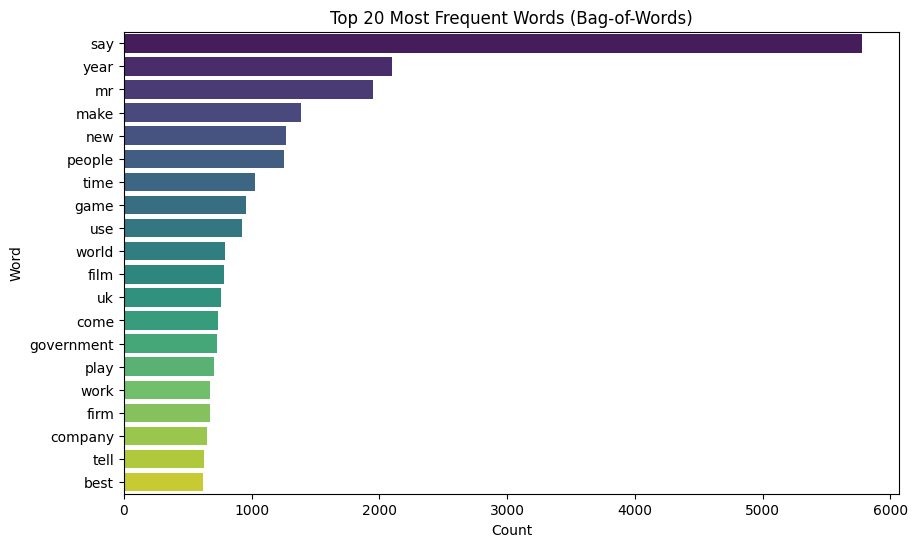

In [ ]:
# Top 20 most frequent words across all documents
feature_names = bow_vectorizer.get_feature_names_out()
word_counts = np.sum(X_train_bow.toarray(), axis=0)
bow_df = pd.DataFrame({'word': feature_names, 'count': word_counts})
bow_df = bow_df.sort_values(by='count', ascending=False) # descending order

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x='count', y='word', data=bow_df.head(20), palette='viridis')
plt.title("Top 20 Most Frequent Words (Bag-of-Words)")
plt.xlabel("Count")
plt.ylabel("Word")
plt.show()

In [ ]:
# Top 10 words in first document
doc_vector = X_train_bow[0] # sparse
doc_array = doc_vector.toarray()[0] # convert to dense array

top_indices = doc_array.argsort()[-10:][::-1]
top_words = [feature_names[i] for i in top_indices]
top_counts = doc_array[top_indices]

print(f"First Document Category: {y_train[0]}")
print("\nTop 10 Words (BoW):")
for word, count in zip(top_words, top_counts):
    print(f"{word}: {count}")


First Document Category: business

Top 10 Words (BoW):
worldcom: 9
mr: 7
accounting: 6
ebbers: 6
say: 5
fraud: 4
cooper: 4
chief: 3
lawyer: 3
charge: 3


## Call TF-IDF Function

In [ ]:
X_train_tfidf, X_test_tfidf, vectorizer = tf_idf(X_train, X_test, return_vectorizer=True)
feature_names = vectorizer.get_feature_names_out()

Vocabulary size: 221705
Training matrix shape: (1460, 221705)
Testing matrix shape: (735, 221705)


In [ ]:
# from scipy import sparse
# from google.colab import files

# # Save the matrices
# sparse.save_npz("X_train_tfidf.npz", X_train_tfidf)
# sparse.save_npz("X_test_tfidf.npz", X_test_tfidf)

# # Download them
# files.download("X_train_tfidf.npz")
# files.download("X_test_tfidf.npz")

/tmp/ipython-input-3945521957.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='tfidf', y='word', data=tfidf_df.head(20), palette='viridis')


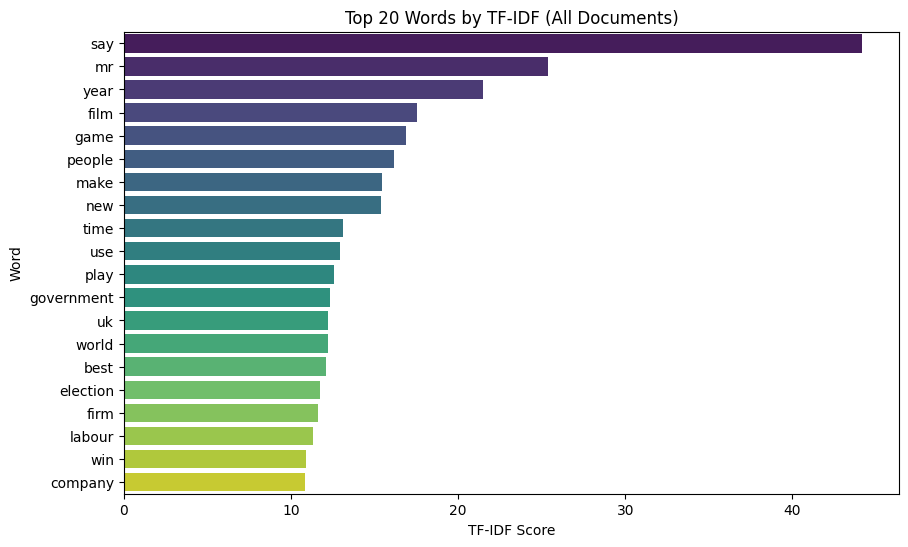

In [ ]:
# Inspect top 20 words across all documents
tfidf_sum = np.array(X_train_tfidf.sum(axis=0)).flatten()
tfidf_df = pd.DataFrame({'word': feature_names, 'tfidf': tfidf_sum})
tfidf_df = tfidf_df.sort_values(by='tfidf', ascending=False)

# Plot
plt.figure(figsize=(10,6))
sns.barplot(x='tfidf', y='word', data=tfidf_df.head(20), palette='viridis')
plt.title("Top 20 Words by TF-IDF (All Documents)")
plt.xlabel("TF-IDF Score")
plt.ylabel("Word")
plt.show()

In [ ]:
# Inspect top 10 words in fourth document
doc_vector = X_train_tfidf[3]
doc_array = doc_vector.toarray()[0]

top_indices = doc_array.argsort()[-10:][::-1]
top_words = [feature_names[i] for i in top_indices]
top_scores = doc_array[top_indices]

print(f"Fourth Document Category: {y_train[3]}")
print("\nTop 10 Words (TF-IDF):")
for word, score in zip(top_words, top_scores):
    print(f"{word}: {score:.3f}")

Fourth Document Category: tech

Top 10 Words (TF-IDF):
phone: 0.274
camera: 0.245
bjorn: 0.220
dr bjorn: 0.191
ericsson: 0.165
use: 0.155
bjorn say: 0.153
dr: 0.153
mobile: 0.145
camera phone: 0.127


## Call Word2Vec Function

In [ ]:
X_train_wv, X_test_wv, wv_model = word2vec_embeddings(X_train['Text'], X_test['Text'])

Training matrix shape: (1460, 100)
Testing matrix shape: (735, 100)


In [ ]:
# # Convert to DataFrames
# X_train_df = pd.DataFrame(X_train_wv)
# X_test_df = pd.DataFrame(X_test_wv)

# # Save and download
# X_train_df.to_csv('X_train_wv.csv', index=False)
# X_test_df.to_csv('X_test_wv.csv', index=False)

# files.download('X_train_wv.csv')
# files.download('X_test_wv.csv')

In [ ]:
print("Vocabulary size:", len(wv_model.wv))
print("Sample words:", list(wv_model.wv.index_to_key[:20]))

Vocabulary size: 12063
Sample words: ['say', 'year', 'mr', 'would', 'also', 'make', 'new', 'people', 'us', 'one', 'take', 'go', 'time', 'could', 'game', 'get', 'use', 'last', 'first', 'two']


In [ ]:
# Inspect word vector for a single word
word = "thank"
if word in wv_model.wv:
    print(f"Vector for '{word}':\n", wv_model.wv[word][:10])  # first 10 dims
else:
    print(f"'{word}' not in vocabulary")

Vector for 'thank':
 [-0.2174315   0.24816611 -0.0522756   0.09514194  0.04514696 -0.31917053
 -0.01808631  0.3722797   0.02128708 -0.07937363]


In [ ]:
# Top 10 most similar words to "game"
wv_model.wv.most_similar("game", topn=10)

[('gb', 0.8311679363250732),
 ('display', 0.8248732089996338),
 ('title', 0.8193444013595581),
 ('xbox', 0.8104036450386047),
 ('impressive', 0.8042041063308716),
 ('gamers', 0.8007594347000122),
 ('console', 0.7956538796424866),
 ('halo', 0.7949191331863403),
 ('playing', 0.7825092077255249),
 ('atmosphere', 0.7811944484710693)]

In [ ]:
wv_model.wv.doesnt_match(["goal", "team", "match", "president"])

'president'

In [ ]:
wv_model.wv.most_similar("football")

[('rugby', 0.9272834658622742),
 ('team', 0.9207836389541626),
 ('laporte', 0.9130957126617432),
 ('gerrard', 0.911912202835083),
 ('mourinho', 0.9056004285812378),
 ('league', 0.9051564931869507),
 ('chelsea', 0.9047558307647705),
 ('barcelona', 0.9028090238571167),
 ('fulham', 0.9027844071388245),
 ('newcastle', 0.9015424847602844)]

In [ ]:
# Top 10 most similar words to 'movie'
wv_model.wv.most_similar("movie", topn=10)

[('studio', 0.9483757019042969),
 ('art', 0.9317581653594971),
 ('feature', 0.9213684797286987),
 ('original', 0.9202706217765808),
 ('artist', 0.9187118411064148),
 ('episode', 0.9163787364959717),
 ('interactive', 0.9138166904449463),
 ('song', 0.9121320247650146),
 ('screen', 0.9023707509040833),
 ('pop', 0.9013847708702087)]

In [ ]:
# Analogy: "actor" is to "film" as ____ is to "music"
# Returns top 5 words that best fit this analogy
wv_model.wv.most_similar(positive=["actor", "music"], negative=["film"], topn=5)

[('hip', 0.7334597110748291),
 ('interactive', 0.7269375920295715),
 ('scene', 0.7196269631385803),
 ('boy', 0.711879551410675),
 ('rock', 0.709328293800354)]

In [ ]:
# Should see "queen" on large data sets
wv_model.wv.most_similar(positive=["king", "woman"], negative=["man"], topn=5)

[('panel', 0.8631524443626404),
 ('reunite', 0.8623989224433899),
 ('dancer', 0.8566616773605347),
 ('diary', 0.8561838269233704),
 ('influential', 0.8540316820144653)]

In [ ]:
from collections import Counter
import re

# Count occurrences of the target word
target = "queen"
print("Count in raw training text:", X_train['Text'].str.lower().str.count(r'\b'+target+r'\b').sum())

# Print a few contexts where it appears
for doc in X_train['Text'].sample(50, random_state=1).tolist():
    if re.search(r'\b'+target+r'\b', doc, flags=re.I):
        pos = re.search(r'\b'+target+r'\b', doc, flags=re.I).start()
        print("...", doc[max(0,pos-80):pos+80].replace("\n"," "), "\n")


Count in raw training text: 45


## Call Word2Vec + Tf-idf Function

In [ ]:
X_train_wv_if, X_test_wv_if, wv_if_model = word2vec_tfidf_embeddings(X_train['Text'], X_test['Text'], vectorizer, return_model=True)

Word2Vec+TFIDF shapes: (1460, 100) (735, 100)


In [ ]:
print("Vocabulary size:", len(wv_if_model.wv))
print("Sample words:", list(wv_if_model.wv.index_to_key[:20]))

Vocabulary size: 19053
Sample words: ['say', 'year', 'mr', 'would', 'also', 'make', 'new', 'people', 'us', 'one', 'take', 'go', 'time', 'could', 'game', 'get', 'use', 'last', 'first', 'two']


In [ ]:
# Inspect word vector for a single word
word = "love"
if word in wv_if_model.wv:
    print(f"Vector for '{word}':\n", wv_if_model.wv[word][:10])  # first 10 dims
else:
    print(f"'{word}' not in vocabulary")

Vector for 'love':
 [-0.26954898  0.2448169   0.16398014 -0.0593866   0.09343746 -0.28612393
  0.05984859  0.39538044  0.16826275 -0.12142506]


In [ ]:
# Top 10 most similar words to "movie"
wv_if_model.wv.most_similar("movie", topn=10)

[('original', 0.9334204196929932),
 ('studio', 0.9301854372024536),
 ('art', 0.9299604892730713),
 ('artist', 0.9128990173339844),
 ('classic', 0.9042949676513672),
 ('episode', 0.9036867618560791),
 ('song', 0.9028549194335938),
 ('feature', 0.8997683525085449),
 ('dvd', 0.8905407190322876),
 ('edit', 0.8900468349456787)]

In [ ]:
# Analogy: "actor" is to "film" as ____ is to "music"
# Returns top 5 words that best fit this analogy
wv_if_model.wv.most_similar(positive=["actor", "music"], negative=["film"], topn=5)

[('scene', 0.7253881692886353),
 ('mtv', 0.7118541598320007),
 ('interactive', 0.7088844180107117),
 ('rock', 0.708799421787262),
 ('dance', 0.7044640779495239)]

In [ ]:
# Should see "queen" on large data sets
wv_if_model.wv.most_similar(positive=["king", "woman"], negative=["man"], topn=5)

[('breakfast', 0.8331162333488464),
 ('true', 0.8317840099334717),
 ('frost', 0.8303045630455017),
 ('icm', 0.8291559815406799),
 ('no', 0.8249640464782715)]

Encode categories and append them to data

In [ ]:
df_train = pd.DataFrame(X_train_wv_if)
mapping = {'business': 0, 'entertainment': 1, 'politics': 2, 'sport': 3, 'tech': 4}
encoded_y_train = y_train.map(mapping)
#df_train['Category'] = encoded_y_train
df_train['Category'] = y_train
#not sure why this is a float, and the other is an int---shouldn't affect us in the long run
df_train.head(10)

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,Category
0,-0.167664,0.137043,0.190472,0.217936,-0.048796,-0.261599,-0.086247,0.234256,-0.184003,0.073167,...,0.092997,0.118450,0.064518,0.250136,0.280634,0.091250,-0.249818,0.063436,-0.154787,business
1,-0.203886,0.238897,0.233740,0.036703,-0.008491,-0.391642,-0.004398,0.312351,-0.104643,-0.022248,...,0.050264,-0.007972,0.079269,0.192287,0.313462,-0.044398,-0.099581,-0.033831,-0.229054,business
2,-0.122577,0.229748,0.176057,0.089185,0.008692,-0.334487,0.022509,0.332432,-0.094979,-0.007856,...,0.074583,0.012177,0.115205,0.257389,0.234989,-0.020181,-0.162743,0.017585,-0.193451,business
3,-0.150792,0.190192,0.291287,0.074636,0.037388,-0.369804,0.043176,0.405337,-0.126392,0.015258,...,0.079281,0.112292,0.130163,0.302905,0.258858,-0.041819,-0.227530,0.016137,-0.091127,tech
4,-0.184957,0.136404,0.188907,0.176161,-0.048582,-0.312080,-0.029565,0.252602,-0.105562,0.051204,...,0.099072,0.078133,0.085321,0.226007,0.272641,0.055781,-0.202225,0.037754,-0.136450,business
5,-0.053142,0.217459,0.107535,0.063018,0.029089,-0.253817,0.036027,0.316788,-0.072397,-0.037202,...,0.029839,0.112520,0.149037,0.295563,0.202915,0.059122,-0.262470,0.101855,-0.135429,politics
6,0.024577,0.267398,0.082288,-0.040856,0.076963,-0.338905,0.030038,0.348930,0.007341,-0.083096,...,-0.051877,0.161273,0.139951,0.257379,0.240373,0.074215,-0.319654,0.110097,-0.163790,sport
7,-0.186397,0.182035,0.161915,0.061069,0.033076,-0.292350,-0.017763,0.213067,-0.022855,0.014479,...,0.032345,0.100367,0.135955,0.243254,0.235267,0.076918,-0.270669,0.123654,-0.073330,entertainment
8,-0.217222,0.173307,0.264547,0.046655,-0.065844,-0.355937,-0.109093,0.266651,-0.032445,-0.006202,...,0.075562,0.111311,0.059427,0.130764,0.339252,-0.041328,-0.077046,-0.026975,-0.206280,business
9,-0.133007,0.139626,0.236035,0.040171,0.066048,-0.387125,-0.027247,0.213714,0.064775,-0.002270,...,0.044031,0.045819,0.159312,0.204658,0.318446,-0.029874,-0.251570,0.034358,-0.110925,entertainment


In [ ]:
df_test = pd.DataFrame(X_test_wv_if)
mapping = {'business': 0, 'entertainment': 1, 'politics': 2, 'sport': 3, 'tech': 4}
encoded_y_test = y_test.map(mapping)
#df_test['Category'] = encoded_y_test
df_test['Category'] = y_test
df_test.head(10)

,0,1,2,3,4,5,6,7,8,9,...,91,92,93,94,95,96,97,98,99,Category
0,-0.089214,0.219989,0.146536,0.044163,0.016999,-0.299674,-0.014830,0.269974,-0.014460,-0.023411,...,-0.028548,0.151369,0.079855,0.211396,0.250334,0.073236,-0.266967,0.077171,-0.122632,sport
1,-0.222220,0.190876,0.241341,0.198954,-0.031391,-0.316350,0.051481,0.347139,-0.124598,0.052865,...,0.115605,0.079851,0.071918,0.298798,0.264538,0.033208,-0.214418,0.042430,-0.034410,tech
2,-0.030857,0.237164,0.120281,-0.006005,0.062162,-0.295452,-0.005973,0.308969,0.063564,-0.022744,...,-0.082091,0.212664,0.138558,0.213545,0.243664,0.112131,-0.362794,0.136615,-0.137356,business
3,-0.163057,0.157183,0.175558,0.126442,-0.037466,-0.308184,-0.025136,0.247650,-0.093684,0.050040,...,0.069911,0.058836,0.060613,0.222471,0.256527,0.035333,-0.169555,0.023169,-0.159256,entertainment
4,-0.040806,0.218450,0.140265,0.024864,0.027973,-0.317487,-0.002521,0.282505,0.001485,-0.043046,...,-0.020491,0.157590,0.102028,0.215590,0.258687,0.057044,-0.289536,0.068287,-0.137897,politics
5,0.001161,0.280430,0.124953,0.073549,0.039643,-0.328444,0.061725,0.372985,-0.062390,-0.087455,...,-0.035662,0.159424,0.130625,0.297357,0.229141,0.057132,-0.268616,0.149847,-0.144847,sport
6,-0.081385,0.308042,0.146704,0.080203,-0.007627,-0.302223,0.011821,0.354718,-0.246064,-0.039313,...,0.040650,0.038432,0.042108,0.391700,0.194000,0.069542,-0.183450,0.032227,-0.254249,tech
7,-0.078488,0.197069,0.129732,0.084759,0.004043,-0.290238,0.026720,0.251262,-0.104169,0.005320,...,-0.004053,0.095181,0.103829,0.254950,0.201537,0.101456,-0.266691,0.092018,-0.125438,business
8,-0.194598,0.200156,0.169935,-0.003031,0.040405,-0.296527,-0.015854,0.257476,0.115473,-0.023992,...,0.051776,0.179574,0.181237,0.236849,0.250139,0.083427,-0.341593,0.146753,-0.017211,entertainment
9,-0.221543,0.162933,0.244507,0.131148,-0.080797,-0.319594,-0.064918,0.297820,-0.111718,0.012763,...,0.078345,0.031911,0.058732,0.206456,0.300207,-0.014338,-0.117583,0.021466,-0.241849,politics


Download preprocessed data to our drive

In [ ]:
pd.DataFrame(df_train).to_csv('X_train_wv_tfidf.csv')
!cp X_train_wv_tfidf.csv "/content/drive/MyDrive/BTTAI - News AI Agent/Data"

In [ ]:
pd.DataFrame(df_test).to_csv('X_test_wv_tfidf.csv')
!cp X_test_wv_tfidf.csv "/content/drive/MyDrive/BTTAI - News AI Agent/Data"

## Call Google Word2Vec function (no TF-IDF weighting)

In [ ]:
X_train_google_wv, X_test_google_wv = google_word2vec_documents(
    X_train['Text'],
    X_test['Text'],
    wordvec2_model_loaded
)

print(X_train_google_wv.shape)
print(X_test_google_wv.shape)

(1460, 300)
(735, 300)


In [ ]:
# save train and test to drive
np.save("/content/drive/MyDrive/BTTAI - News AI Agent/Data/X_train_google_wv.npy", X_train_google_wv)
np.save("/content/drive/MyDrive/BTTAI - News AI Agent/Data/X_test_google_wv.npy", X_test_google_wv)

## Call Google Word2Vec + TF-IDF function

In [ ]:
X_train_google_w2v_tfidf, X_test_google_w2v_tfidf = google_w2v_tf_idfdocuments(
    X_train['Text'],
    X_test['Text'],
    wordvec2_model_loaded
)

In [ ]:
print(X_train_google_w2v_tfidf.shape)
print(X_test_google_w2v_tfidf.shape)

(1460, 300)
(735, 300)


In [ ]:
# save train and test to drive
np.save("/content/drive/MyDrive/BTTAI - News AI Agent/Data/X_train_google_wv_tfidf.npy", X_train_google_w2v_tfidf)
np.save("/content/drive/MyDrive/BTTAI - News AI Agent/Data/X_test_google_wv_tfidf.npy", X_test_google_w2v_tfidf)